# Kaggle's Dats Science Bowl 2018 competition

Code below initially heavily based on:
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
and
https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation

## Set seeds

In [1]:
RANDOM_STATE = 42

from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set constants

In [2]:
# IMG_WIDTH = 256
# IMG_HEIGHT = 256
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_NUM_CHANNELS = 3
NUM_CLASSES = 2

PRED_THRESHOLD = 0.5

PATH_TRAINING = "../data/kaggle_data_science_bowl_2018/stage1_train"
PATH_TEST = "../data/kaggle_data_science_bowl_2018/stage1_test"
# PATH_TRAINING = "../input/stage1_train/"     # Kaggle kernel
# PATH_TEST = "../input/stage1_test/"          # Kaggle kernel
SUBFOLDER_IMAGES = "images"
SUBFOLDER_MASKS = "masks"
SUFFIX = ".png"
FILE_SUFFIX = "128bn-aug-shuf-ecxl"     # Change this to give output files meaningfil names

MODEL_PATH = "../savedmodels"
OUTPUT_PATH = "../output"
# MODEL_PATH = ""                               # Kaggle kernel
# OUTPUT_PATH = ""                              # Kaggle kernel

NUM_EPOCH = 70
BATCH_SIZE = 8
TRAIN_VAL_SPLIT = 0.1
STEPS_PER_EPOCH = 250
DROPOUT_RATE1 = 0.1
DROPOUT_RATE2 = 0.2
DROPOUT_RATE3 = 0.3

## Import packages

In [3]:
from keras.models import load_model
from keras import backend as K
from keras.layers import Input, Conv2D, Dropout,MaxPooling2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
import cv2
import progressbar
import numpy as np
import pandas as pd
import io, os, time

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Helper functions

In [4]:
def load_data(source_path, is_training=False):
    """
    Load images and associated segmented masks
    :param source_path: path to the data set
    :param is_training: True when loading the training set to also load the masks
    :return: for the training set: two numpy arrays, one with the images, another with the masks
             for the test set: one numpy array with images, one list with original image resolutions
    """
    start_time = time.time()
    
    images = []
    masks = []
    org_sizes = []

    # Traverse subfolders, read the image and, for the training set only, the masks
    img_folders = next(os.walk(source_path))[1]
    
    widgets = ["Loading " + ("training" if is_training else "test") + " data ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(img_folders), widgets=widgets).start()

    for i, img_file_name in enumerate(img_folders):
        # Exclude images with incorrect masks: https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770
        if img_file_name == "7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80":
            continue
        
        # Path to the current image subfolder
        full_path = os.path.join(source_path, img_file_name)

        # Path to the single image
        image_path = os.path.join(full_path, SUBFOLDER_IMAGES)
        image_path = os.path.join(image_path, img_file_name + SUFFIX)

        # Read and resize, leave off the alpha channel (some images have alpha channels, not all)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)[:,:,:IMG_NUM_CHANNELS]

        # Store the image's original resolution (only needed for test images)
        if not is_training:
            org_sizes.append(img.shape[0:2])

        # Resize to standard dimensions
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)

        images.append(img)    
        pbar.update(i)

        # Load individual masks and combine into one mask image (training set only)
        if is_training:
            mask_path = os.path.join(full_path, SUBFOLDER_MASKS)
            mask = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

            mask_files = next(os.walk(mask_path))[2]
            for _, mask_file in enumerate(mask_files):
                # Ignore incorrect masks
                if mask_file == "a09ae9559f817b104e049e5bb01cf4ad1b87e3ef7fad3dcf932b6585ca3edc05.png":
                    continue

                # Read the mask and combine it with the previous masks
                tmp_mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)

                tmp_mask = cv2.threshold(tmp_mask, 127, 1.0, cv2.THRESH_BINARY)[1]
                tmp_mask = cv2.resize(tmp_mask, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                
                tmp_mask = np.expand_dims(tmp_mask, axis=-1)
                mask = np.maximum(mask, tmp_mask).astype(np.bool)

            # Add the combined masks (this works because pixels belong to only one mask)
            masks.append(mask)

    pbar.finish()
    print("Elapsed time: {}".format(time.time() - start_time))
    
    if is_training:
        return np.array(images, dtype=np.uint8), np.array(masks, dtype=np.bool)
    else:
        return np.array(images, dtype=np.uint8), org_sizes

In [5]:
def mean_iou(y_true, y_pred):
    """Calculate the score as defined by the competition, courtesy of:
    https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    """
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    
    return K.mean(K.stack(prec), axis=0)

## U-nets

## U-Net 128x128x3 with BN instead of Dropout

In [6]:
def create_unet128_bn(img_height, img_width, img_num_channels):
    """Create a U-Net model for 128x128x3 inputs with Dropout. Courtesy of:
    https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    """
    inputs = Input((img_height, img_width, img_num_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### U-Net 128x128x3 with Dropout

### U-Net 256x256x3

### U-Net 128x128x3 alternate: no dropout, one less layer

## Submission file creation

In [7]:
def rle_encoding(img):
    """Courtesy of: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python"""
    pixels = np.where(img.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in pixels:
        if (b > prev+1):
            run_lengths.extend((b + 1, 0))

        run_lengths[-1] += 1
        prev = b

    return run_lengths

def prob_to_rles(x, cutoff=PRED_THRESHOLD):
    """Courtesy of: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python"""
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
def create_submission_file(preds, path, org_sizes):
    """Create a file with run-length encoding on the pixel values
    Courtesy of: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
    """
    start_time = time.time()

    # Resize the predictions to the size of the original image (images do not all have the same resolution)
    img_folders = next(os.walk(path))[1]
    preds_org_size = []
    for i in range(len(preds)):
        preds_org_size.append(cv2.resize(np.squeeze(preds[i]),
                                           (org_sizes[i][0], org_sizes[i][1]),
                                           interpolation=cv2.INTER_AREA))

    new_test_ids = []
    rles = []
    for n, id_ in enumerate(img_folders):
        rle = list(prob_to_rles(preds_org_size[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))

    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(os.path.join(OUTPUT_PATH, "{}-submission.csv".format(FILE_SUFFIX)), index=False)
    
    print("Elapsed time: {}".format(time.time() - start_time))

## Start training

In [8]:
# Load and shuffe the training data
X_full, Y_full = load_data(PATH_TRAINING, is_training=True)
idx = np.random.permutation(len(X_full))
X_full, Y_full = X_full[idx], Y_full[idx]

# Load the test data
X_test, test_org_sizes = load_data(PATH_TEST, is_training=False)

Loading training data 100% |####################################| Time: 0:00:34
Loading test data  27% |###########                             | ETA:  0:00:00

Elapsed time: 34.93809723854065


Loading test data 100% |########################################| Time: 0:00:00


Elapsed time: 0.3199269771575928


In [9]:
# Prepare paths
model_path = os.path.join(MODEL_PATH, "{}.model".format(FILE_SUFFIX))
csv_path = os.path.join(OUTPUT_PATH, "{}-training.csv".format(FILE_SUFFIX))

In [13]:
# Create the Keras model
# u_net_model = create_unet256(IMG_HEIGHT, IMG_WIDTH, IMG_NUM_CHANNELS)
# u_net_model = create_unet128(IMG_HEIGHT, IMG_WIDTH, IMG_NUM_CHANNELS)
u_net_model = create_unet128_bn(IMG_HEIGHT, IMG_WIDTH, IMG_NUM_CHANNELS)
# u_net_model = create_unet128_alt(IMG_HEIGHT, IMG_WIDTH, IMG_NUM_CHANNELS)

# Compile
# u_net_model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef, 'acc', 'mse'])
u_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
u_net_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [14]:
def create_data_generators(X, Y):
    """Create Keras image data generators"""
    # Split the training set into a training and validation set
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=TRAIN_VAL_SPLIT, random_state=RANDOM_STATE)

    # Create generator arguments
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

    # Create and fit the training data generators
    train_image_datagen = ImageDataGenerator(**data_gen_args)
    train_mask_datagen = ImageDataGenerator(**data_gen_args)

    train_image_datagen.fit(X_train, augment=True, seed=RANDOM_STATE)
    train_mask_datagen.fit(Y_train, augment=True, seed=RANDOM_STATE)

    train_image_gen = train_image_datagen.flow(X_train, batch_size=BATCH_SIZE, shuffle=True, seed=RANDOM_STATE)
    train_mask_gen = train_mask_datagen.flow(Y_train, batch_size=BATCH_SIZE, shuffle=True, seed=RANDOM_STATE)

    train_generator = zip(train_image_gen, train_mask_gen)

    # Create the validation data generators (do not apply any augmentation)
    val_image_datagen = ImageDataGenerator()
    val_mask_datagen = ImageDataGenerator()

    val_image_gen = val_image_datagen.flow(X_val, batch_size=BATCH_SIZE, shuffle=True, seed=RANDOM_STATE)
    val_mask_gen = val_mask_datagen.flow(Y_val, batch_size=BATCH_SIZE, shuffle=True, seed=RANDOM_STATE)

    val_generator = zip(val_image_gen, val_mask_gen)
    
    return train_generator, val_generator, len(X_train), len(X_val)

In [15]:
# Fit
start_time = time.time()
callbacks = [ModelCheckpoint(model_path, monitor="val_loss", mode="auto", save_best_only=True, verbose=1),
             EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode="auto"),
             CSVLogger(csv_path, append=False)
             ]

# WITHOUT data augmentation
# history = u_net_model.fit(x=X_full,
#                           y=Y_full,
#                           validation_split=TRAIN_VAL_SPLIT,
#                           batch_size=BATCH_SIZE,
#                           epochs=NUM_EPOCH,
#                           verbose=1,
#                           callbacks=callbacks)

# WITH data augmentation
train_gen, val_gen, len_train, len_val = create_data_generators(X_full, Y_full)
history = u_net_model.fit_generator(generator=train_gen,
                                    validation_data=val_gen,
                                    steps_per_epoch=2*len_train/BATCH_SIZE,
                                    validation_steps=len_val/BATCH_SIZE,
                                    epochs=NUM_EPOCH,
                                    verbose=1,
                                    callbacks=callbacks)

print("Elapsed training time: {}".format(time.time() - start_time))

Epoch 1/70
151/150 [==============================] - 133s 884ms/step - loss: 0.1862 - mean_iou: 0.6421 - val_loss: 0.0954 - val_mean_iou: 0.7193

Epoch 00001: val_loss improved from inf to 0.09535, saving model to ../savedmodels/gb-full-128bn-aug-shuf-ecxl.model
Epoch 2/70
151/150 [==============================] - 132s 873ms/step - loss: 0.1073 - mean_iou: 0.7435 - val_loss: 0.0865 - val_mean_iou: 0.7603

Epoch 00002: val_loss improved from 0.09535 to 0.08652, saving model to ../savedmodels/gb-full-128bn-aug-shuf-ecxl.model
Epoch 3/70
151/150 [==============================] - 136s 899ms/step - loss: 0.1057 - mean_iou: 0.7705 - val_loss: 0.1860 - val_mean_iou: 0.7758

Epoch 00003: val_loss did not improve
Epoch 4/70
151/150 [==============================] - 137s 908ms/step - loss: 0.1141 - mean_iou: 0.7768 - val_loss: 0.0722 - val_mean_iou: 0.7798

Epoch 00004: val_loss improved from 0.08652 to 0.07220, saving model to ../savedmodels/gb-full-128bn-aug-shuf-ecxl.model
Epoch 5/70
151/

Text(0.5,1,'IoU Curves')

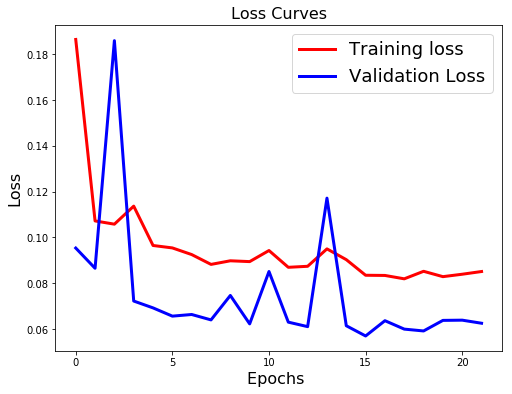

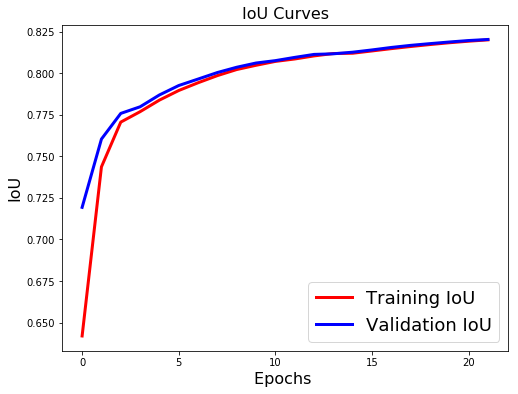

In [16]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# IoU Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['mean_iou'],'r',linewidth=3.0)
plt.plot(history.history['val_mean_iou'],'b',linewidth=3.0)
plt.legend(['Training IoU', 'Validation IoU'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('IoU',fontsize=16)
plt.title('IoU Curves',fontsize=16)

In [17]:
# Make predictions
u_net_model = load_model(model_path, custom_objects={"mean_iou": mean_iou})
# u_net_model = load_model(model_path, custom_objects={"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss})

test_pred = u_net_model.predict(X_test, verbose=1)
test_pred_thresh = (test_pred > PRED_THRESHOLD).astype(np.uint8)

65/65 [==============================] - 3s 46ms/step


Text(0.5,1,'Prediction')

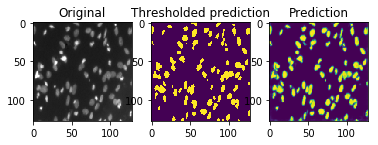

In [18]:
# Show images and (predicted) masks
ix = 64
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(np.squeeze(X_test[ix]))
axarr[0].set_title("Original")
axarr[1].imshow(np.squeeze(test_pred_thresh[ix]))
axarr[1].set_title("Thresholded prediction")
axarr[2].imshow(np.squeeze(test_pred[ix]))
axarr[2].set_title("Prediction")

In [19]:
# Produce submission file
# create_submission_file(test_pred_thresh, PATH_TEST, test_org_sizes)
create_submission_file(test_pred, PATH_TEST, test_org_sizes)

Elapsed time: 2.164060115814209
